In [1]:
#import required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten

Using TensorFlow backend.


In [2]:
#load data

pickle_in = open('flowDict.pickle','rb')
flowDict = pickle.load(pickle_in)

pickle_in = open('tempDict.pickle','rb')
tempDict = pickle.load(pickle_in)

pickle_in = open('precDict.pickle','rb')
precDict = pickle.load(pickle_in)

In [3]:
#unpack data

stationLat = flowDict['stationLat']
stationLon = flowDict['stationLon']
eraLat = tempDict['latERA']
eraLon = tempDict['lonERA']

flowDays = flowDict['windowDays']
flowMonths = flowDict['windowMonths']
flowYears = flowDict['windowYears']
eraDays = tempDict['daysERA']
eraMonths = tempDict['monthsERA']
eraYears = tempDict['yearsERA']

F = flowDict['all_flowwindow_norm_NF'] #normalized discharge with nans filled (NF)
#F = np.reshape(F,(194,8766)).T
T = tempDict['T']
P = precDict['P']

In [4]:
#make data have same time range
startYear = max(int(np.min(eraYears)),int(np.min(flowYears)))

indStartERA = min(np.argwhere(eraYears==startYear))[0]
indStartFlow = min(np.argwhere(flowYears==startYear))[0]

F = np.asarray(np.transpose(np.squeeze(F[indStartFlow:])))
T = np.asarray(T[indStartERA:])
P = np.asarray(P[indStartERA:])

#just alberta
T = T[:,:,27:]
P = P[:,:,27:]

flowDays = flowDays[indStartFlow:]
flowMonths = flowMonths[indStartFlow:]
flowYears = flowYears[indStartFlow:]

eraDays = eraDays[indStartERA:]
eraMonths = eraMonths[indStartERA:]
eraYears = eraYears[indStartERA:]

In [5]:
#turn T and P daily fields into 1D vectors for PCA
T1d = np.empty((len(T),np.shape(T)[1]*np.shape(T)[2]))
P1d = np.empty_like(T1d)
for day in range(len(T)):
    T1d[day] = np.reshape(T[day],np.shape(T1d[day]))
    P1d[day] = np.reshape(P[day],np.shape(T1d[day]))

In [6]:
#check to make sure that everything is the right size
print('Flow size: ' + str(np.shape(F)[0]) + ' rows, ' + str(np.shape(F)[1]) + ' columns')
print('Temp size: ' + str(np.shape(T1d)[0]) + ' rows, ' + str(np.shape(T1d)[1]) + ' columns')
print('Prec size: ' + str(np.shape(P1d)[0]) + ' rows, ' + str(np.shape(P1d)[1]) + ' columns')

Flow size: 8766 rows, 194 columns
Temp size: 8766 rows, 272 columns
Prec size: 8766 rows, 272 columns


In [7]:
#do PCA!

#flow
n_modesF = np.min(np.shape(F))
pcaF = PCA(n_components = n_modesF)
PCsF = pcaF.fit_transform(F)
eigvecsF = pcaF.components_
fracVarF = pcaF.explained_variance_ratio_

#temp
n_modesT = np.min(np.shape(T1d))
pcaT = PCA(n_components = n_modesT)
PCsT = pcaT.fit_transform(T1d)
eigvecsT = pcaT.components_
fracVarT = pcaT.explained_variance_ratio_

#precip
n_modesP = np.min(np.shape(P1d))
pcaP = PCA(n_components = n_modesP)
PCsP = pcaP.fit_transform(P1d)
eigvecsP = pcaP.components_
fracVarP = pcaP.explained_variance_ratio_

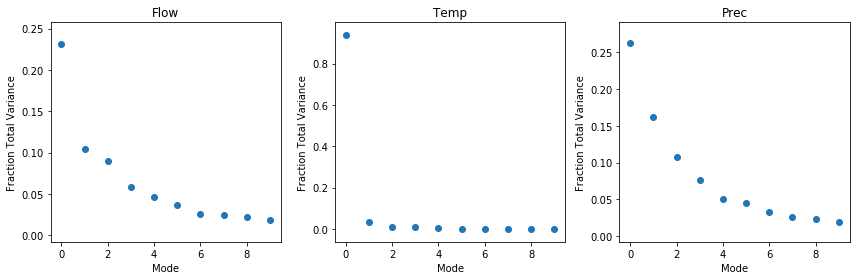

In [8]:
#plot variance explained

plt.figure(figsize=(12,4))

plt.subplot(131)
plt.scatter(range(10),fracVarF[:10])
plt.xlabel('Mode')
plt.ylabel('Fraction Total Variance')
plt.title('Flow')

plt.subplot(132)
plt.scatter(range(10),fracVarT[:10])
plt.xlabel('Mode')
plt.ylabel('Fraction Total Variance')
plt.title('Temp')

plt.subplot(133)
plt.scatter(range(10),fracVarP[:10])
plt.xlabel('Mode')
plt.ylabel('Fraction Total Variance')
plt.title('Prec')

plt.tight_layout()

plt.show()

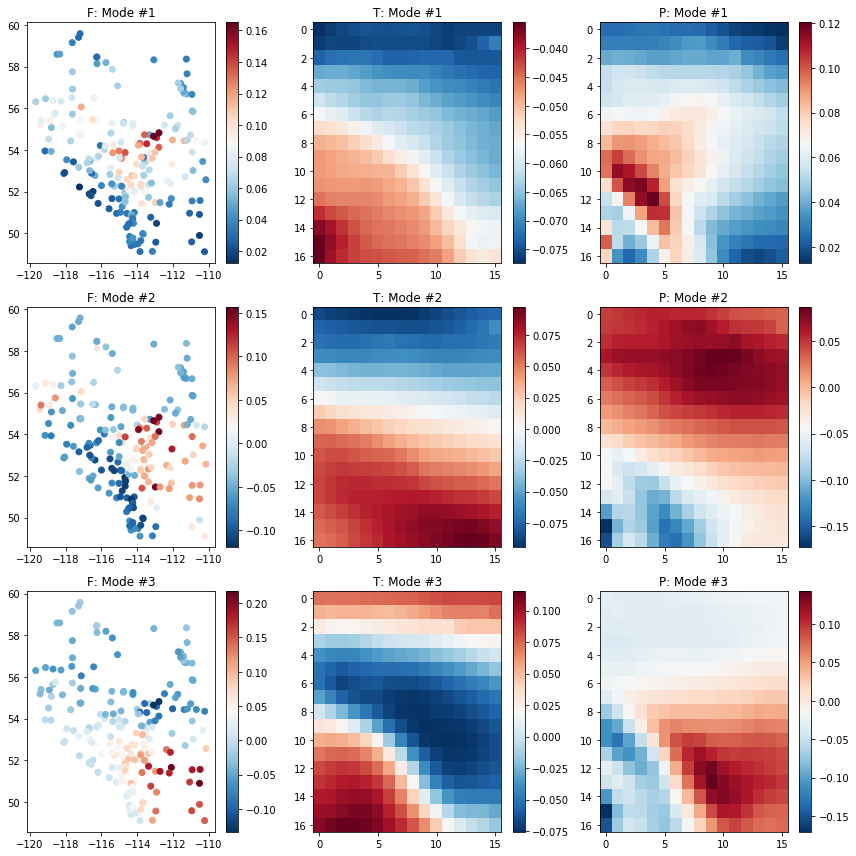

In [13]:
#visualize eigenvectors

n = 3 #number of modes for each variables to visualize

plt.figure(figsize = (12,12))

for kk in range(n):
    
    plt.subplot(n,n,kk*3+1)
    plt.scatter(stationLon,stationLat,c=eigvecsF[kk,:],cmap = 'RdBu_r')
    plt.title('F: Mode #' + str(kk+1))
    plt.colorbar()
    
    plt.subplot(n,n,kk*3+2)
    plt.imshow(np.reshape(eigvecsT[kk,:],np.shape(T[0])),cmap = 'RdBu_r',aspect='auto')
    plt.title('T: Mode #' + str(kk+1))
    plt.colorbar()
    
    plt.subplot(n,n,kk*3+3)
    plt.imshow(np.reshape(eigvecsP[kk,:],np.shape(P[0])),cmap = 'RdBu_r',aspect='auto')
    plt.title('P: Mode #' + str(kk+1))
    plt.colorbar()
    
    plt.tight_layout()


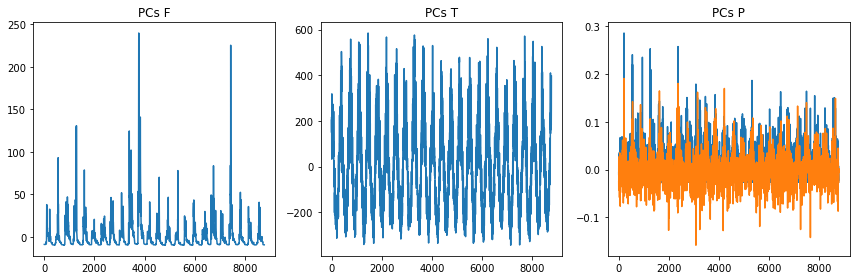

In [19]:
#visualize PCs in 1D, in order to grasp their scale

plt.figure(figsize=(12,4))

plt.subplot(131)
plt.plot(PCsF[:,0])
plt.title('PCs F')

plt.subplot(132)
plt.plot(PCsT[:,0])
plt.title('PCs T')

plt.subplot(133)
plt.plot(PCsP[:,0])
plt.plot(PCsP[:,1])
plt.title('PCs P')

plt.tight_layout()

plt.show()

#conclusion -- these PCs are on hugely different scales!


In [10]:
#prep data for input

n_F = 1
n_T = 1
n_P = 2
timesteps = 365
n_train = 6000 - timesteps
n_test = len(F) - 6000

x_train = np.empty((n_train, timesteps, n_T + n_P))
y_train = np.empty((n_train, n_F))
for kk in range(n_train):
    x_train[kk,:,0] = PCsT[kk:kk+timesteps,0]
    x_train[kk,:,1:] = PCsP[kk:kk+timesteps,:2]
    y_train[kk] = PCsF[kk+timesteps+1,0]
    

x_test = np.empty((n_test, timesteps, n_T + n_P))
y_test = np.empty((n_test,n_F))
jj = 0
for kk in range(n_train + 1, len(PCsT)-timesteps-1):
    x_test[jj,:,0] = PCsT[kk:kk+timesteps,0]
    x_test[jj,:,1:] = PCsP[kk:kk+timesteps,:2]
    y_test[jj] = PCsF[kk+timesteps+1,0]
    jj+=1 
    

In [47]:
#normalize data

x_train_mean = np.empty((n_T+n_P))
x_train_std = np.empty((n_T+n_P))
y_train_mean = np.empty((n_F))
y_train_std = np.empty((n_F))

x_test_mean = np.empty((n_T+n_P))
x_test_std = np.empty((n_T+n_P))
y_test_mean = np.empty((n_F))
y_test_std = np.empty((n_F))

x_train_norm = np.empty_like(x_train)
y_train_norm = np.empty_like(y_train)
x_test_norm = np.empty_like(x_test)
y_test_norm = np.empty_like(y_test)

for xpred in range(n_T + n_P):
    
    x_train_mean[xpred] = np.mean(x_train[:,:,xpred])
    x_train_std[xpred] = np.std(x_train[:,:,xpred])
    x_train_norm[:,:,xpred] = (x_train[:,:,xpred] - x_train_mean[xpred])/x_train_std[xpred]
    x_test_norm[:,:,xpred] = (x_test[:,:,xpred] - x_train_mean[xpred])/x_train_std[xpred]
    
for ypred in range(n_F):

    y_train_mean[ypred] = np.mean(y_train[:,ypred])
    y_train_std[ypred] = np.std(y_train[:,ypred])
    y_train_norm[:,ypred] = (y_train[:,ypred] - y_train_mean[ypred])/y_train_std[ypred]
    y_test_norm[:,ypred] = (y_test[:,ypred] - y_train_mean[ypred])/y_train_std[ypred]
    
x_train = x_train_norm
y_train = y_train_norm
x_test = x_test_norm
y_test = y_test_norm
    

In [48]:
    

#x_train_mean = np.mean(x_train)
#x_train_std = np.std(x_train)
#x_test_mean = np.mean(x_test)
#x_test_std = np.std(x_test)

#y_train_mean = np.mean(y_train)
#y_train_std = np.std(y_train)
#y_test_mean = np.mean(y_test)
#y_test_std = np.std(y_test)

#x_train = (x_train - x_train_mean)/x_train_std
#x_test = (x_test - x_train_mean)/x_train_std

#y_train = (y_train - y_train_mean)/y_train_std
#y_test = (y_test - y_train_mean)/y_train_std

In [49]:
np.shape(x_train)

(5635, 365, 3)

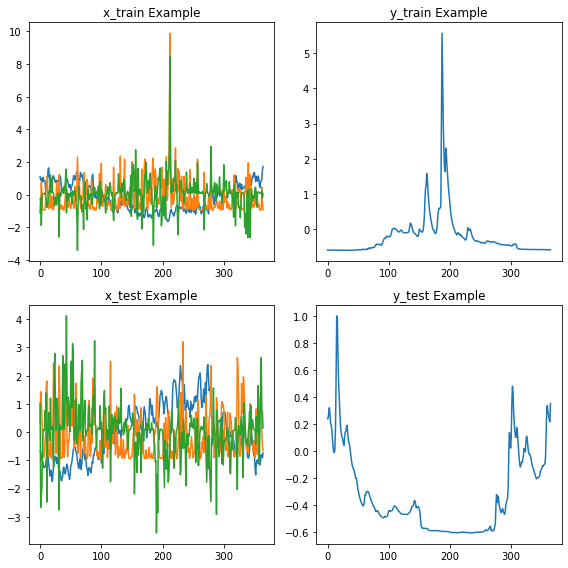

In [50]:
#visualize testing and training data

plt.figure(figsize=(8,8))

plt.subplot(221)
plt.plot(x_train[0])
plt.title('x_train Example')

plt.subplot(222)
plt.plot(y_train[:365])
plt.title('y_train Example')

plt.subplot(223)
plt.plot(x_test[0])
plt.title('x_test Example')

plt.subplot(224)
plt.plot(y_test[:365])
plt.title('y_test Example')

plt.tight_layout()

plt.show()


In [51]:
#build model

model = Sequential()
model.add(LSTM(40, return_sequences=True, input_shape = (timesteps,n_T + n_P)))
model.add(LSTM(20, return_sequences=True))
model.add(Flatten())
model.add(Dense(10, activation = 'tanh'))
model.add(Dense(1, activation = 'linear'))

model.compile(loss='mse',
             optimizer='adam',
             metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [52]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 365, 40)           7040      
_________________________________________________________________
lstm_2 (LSTM)                (None, 365, 20)           4880      
_________________________________________________________________
flatten_1 (Flatten)          (None, 7300)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                73010     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 84,941
Trainable params: 84,941
Non-trainable params: 0
_________________________________________________________________


In [55]:
#train model

model.fit(x_train, y_train, 
          batch_size=64, epochs=5, 
         validation_data=(x_test,y_test))

Train on 5635 samples, validate on 2766 samples
Epoch 1/5
5635/5635 [==============================] - 71s 13ms/step - loss: 0.2783 - acc: 0.0000e+00 - val_loss: 0.6394 - val_acc: 0.0000e+00
Epoch 2/5
5635/5635 [==============================] - 76s 14ms/step - loss: 0.2475 - acc: 0.0000e+00 - val_loss: 0.5266 - val_acc: 0.0000e+00
Epoch 3/5
5635/5635 [==============================] - 72s 13ms/step - loss: 0.1963 - acc: 0.0000e+00 - val_loss: 0.5451 - val_acc: 0.0000e+00
Epoch 4/5
5635/5635 [==============================] - 77s 14ms/step - loss: 0.1737 - acc: 0.0000e+00 - val_loss: 0.5174 - val_acc: 0.0000e+00
Epoch 5/5
5635/5635 [==============================] - 75s 13ms/step - loss: 0.1438 - acc: 0.0000e+00 - val_loss: 0.5487 - val_acc: 0.0000e+00


In [56]:
y_pred = model.predict(x_test)

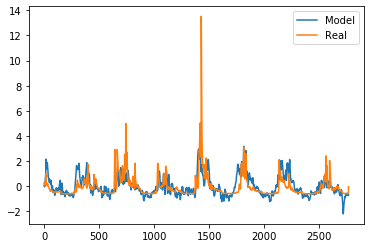

In [57]:
plt.plot(y_pred)
plt.plot(y_test)
plt.legend(('Model','Real'))

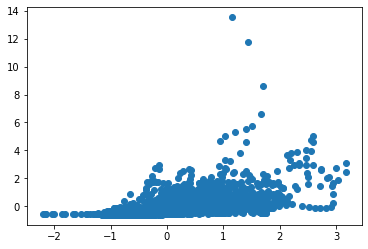

In [58]:
plt.scatter(y_pred,y_test)

In [ ]:
plt.plot